## Introduction
Sentiment analysis, also referred to as opinion mining, is an approach to natural language processing (NLP) that identifies the emotional tone behind a body of text. This is a popular way for organizations to determine and categorize opinions about a product, service or idea. 

The objective of this study is to understand and implement a method of subfield study of NLP which is to transform the words into vectors, and to apply an unsupervised learning model as well as to apply a supervised learning model to make classify BBC News into correct category. In the end, we will compare between supervised and unsupervised learning models.

## Description of dataset
We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

The competition is evaluated using Accuracy as a metric.

## Obtaining the dataset
You can download the dataset in a csv file from Kaggle at following link https://www.kaggle.com/competitions/learn-ai-bbc/overview  
<br>
There are 3 files:  
<br>
BBC News Train.csv - the training set of 1490 records  
BBC News Test.csv - the test set of 736 records  
BBC News Sample Solution.csv - a sample submission file in the correct format  
<br>


## Libraries Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import nltk
import warnings
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from itertools import permutations
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read Dataset

In [2]:
train_df = pd.DataFrame()
train_df = pd.read_csv('learn-ai-bbc/BBC News Train.csv', encoding = 'utf-8')
print('Train Dataset:')
print(train_df.head())

test_df = pd.DataFrame()
test_df = pd.read_csv('learn-ai-bbc/BBC News Test.csv', encoding = 'utf-8')
print('\n\nTest Dataset:')
print(test_df.head())

Train Dataset:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


Test Dataset:
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...


## Data Cleaning and Exploratory Data Analysis (EDA)

After successfully checking that I have got the right data format. Let's do some data checking and cleaning as well as some exploratory analysis.

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [4]:
train_df.describe()

,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


In [5]:
train_df['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

There are five categories named "business", "tech", "politics", "sport" and "entertainment"

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Category Counts')]

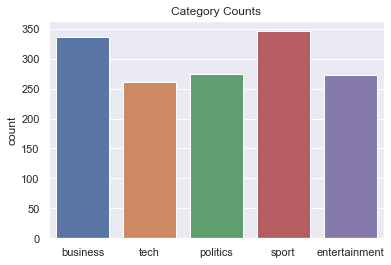

In [6]:
sns.set(style='darkgrid')
sns.countplot(train_df['Category'].values).set(title='Category Counts')

I can see the count of each category is roughly above 250 to 350 per category, and not so much difference between those 5 in term of histogram.

In [7]:
train_df.isna().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

There is no NA values for text or category.

In [8]:
train_df.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

There is no Null values for text or category.

In [9]:
train_df.duplicated().sum()

0

There is no duplicated value in the dataset.

In [10]:
train_df.shape

(1490, 3)

**Let's check out the first news to see what kind of characters in the text. I may need to clean up the non-character words**

In [11]:
train_df['Text']

0       worldcom ex-boss launches defence lawyers defe...
1       german business confidence slides german busin...
2       bbc poll indicates economic gloom citizens in ...
3       lifestyle  governs mobile choice  faster  bett...
4       enron bosses in $168m payout eighteen former e...
                              ...                        
1485    double eviction from big brother model caprice...
1486    dj double act revamp chart show dj duo jk and ...
1487    weak dollar hits reuters revenues at media gro...
1488    apple ipod family expands market apple has exp...
1489    santy worm makes unwelcome visit thousands of ...
Name: Text, Length: 1490, dtype: object

In [12]:
train_df.loc[0,'Text']

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

**I can see that the text contains punctuation other non-letters that need to be removed. I use the Python's regular expression lbirary for the task.**

In [13]:
def preprocessor(text):
    text = re.sub(r'\b\w{1,2}\b', ' ', text.lower())
    text = re.sub('[\W\d]+', ' ', text)
    return text.strip()

The regex \b\w{1,2}\b is used. It matches word boundaries (\b) and checks for words consisting of one or two characters (\w{1,2}). Words that meet this condition are removed.The regex [\W\d]+ is to remove all the non-words character. Finally I convert text into lowercase. Let's see how it works. 

In [14]:
preprocessor(train_df.loc[0,'Text'])

'worldcom boss launches defence lawyers defending former worldcom chief bernie ebbers against battery fraud charges have called company whistleblower their first witness cynthia cooper worldcom head internal accounting alerted directors irregular accounting practices the telecoms giant her warnings led the collapse the firm following the discovery bn bn accounting fraud ebbers has pleaded not guilty charges fraud and conspiracy prosecution lawyers have argued that ebbers orchestrated series accounting tricks worldcom ordering employees hide expenses and inflate revenues meet wall street earnings estimates but cooper who now runs her own consulting business told jury new york wednesday that external auditors arthur andersen had approved worldcom accounting early and she said andersen had given green light the procedures and practices used worldcom ebber lawyers have said was unaware the fraud arguing that auditors did not alert him any problems cooper also said that during shareholder m

**The preprocessor function seems to work well. So let's apply the fuction to the text column.**

In [15]:
train_df['Text'] = train_df['Text'].apply(preprocessor)
train_df['Text']

0       worldcom boss launches defence lawyers defendi...
1       german business confidence slides german busin...
2       bbc poll indicates economic gloom citizens maj...
3       lifestyle governs mobile choice faster better ...
4       enron bosses m payout eighteen former enron di...
                              ...                        
1485    double eviction from big brother model caprice...
1486    double act revamp chart show duo and joel are ...
1487    weak dollar hits reuters revenues media group ...
1488    apple ipod family expands market apple has exp...
1489    santy worm makes unwelcome visit thousands web...
Name: Text, Length: 1490, dtype: object

**The data review column now only contains characters words. Moreover, I want to process each review into tokens so I'll create a tokenizer function as follow**

In [16]:
def tokenizer(text):
    return text.split()

**Stop-word removal: Stop-words are simply the words that are very common in all sort of texts and probably contain no useful information that can be used. Examples of stop-words are *is, are, and, have, has, like, etc.*
We can use the 'stopwords' libary from NLTK library.** 

In [17]:
def stop_words(text):
    stop = stopwords.words('english')
    return [w for w in tokenizer(text) if w not in stop]

**After defining the function stop_words, let's apply stop_words to filter all stop words from our review column.**

In [18]:
txt = train_df['Text'].apply(stop_words)
txt

0       [worldcom, boss, launches, defence, lawyers, d...
1       [german, business, confidence, slides, german,...
2       [bbc, poll, indicates, economic, gloom, citize...
3       [lifestyle, governs, mobile, choice, faster, b...
4       [enron, bosses, payout, eighteen, former, enro...
                              ...                        
1485    [double, eviction, big, brother, model, capric...
1486    [double, act, revamp, chart, show, duo, joel, ...
1487    [weak, dollar, hits, reuters, revenues, media,...
1488    [apple, ipod, family, expands, market, apple, ...
1489    [santy, worm, makes, unwelcome, visit, thousan...
Name: Text, Length: 1490, dtype: object

**Finding the most frequent words in the dataset**

In [19]:
def vocab_count(docs):
    vocab = defaultdict(int)
    for doc in docs:
        for token in doc:            
            if token not in vocab:
                    vocab[token] = 1 
            else:
                    vocab[token] += 1
    return vocab

said : 4839

would : 1714

year : 1528

also : 1426

new : 1338

people : 1324

one : 1249

could : 1032

first : 934

last : 893



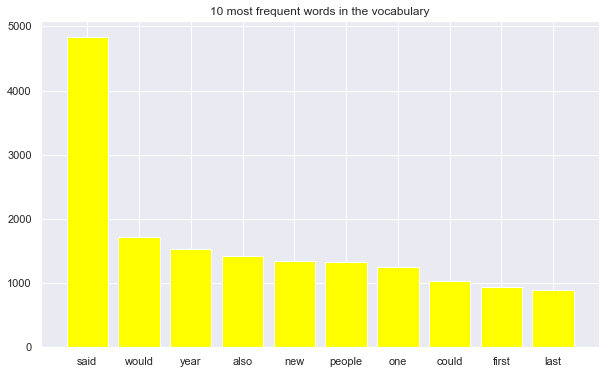

In [20]:
bag_of_words = vocab_count(txt.values)

bag_of_words = {word:count for word,count in sorted(bag_of_words.items(), reverse = True, key = lambda item:item[1])}
words = list(bag_of_words.keys())
counts = list(bag_of_words.values())

for i in range(0,10):
    print(words[i] +' : '+ str(counts[i]) + '\n')

plt.figure(figsize=(10,6))
plt.title('10 most frequent words in the vocabulary')
plt.bar(words[0:10],counts[0:10], color ='yellow')
plt.savefig('10_most_frequent_word.png')
plt.show()

**Now let's print out the 10 most frequent words with its frequencies for each category, then plot the bar graph**

In [21]:
def most_frequent_words(category):
    
    cat = train_df.loc[train_df['Category']== category]
    most_words = vocab_count(cat['Text'].apply(stop_words))
    most_words = {word:count for word,count in sorted(most_words.items(), reverse = True, key = lambda item:item[1])}

    words = list(most_words.keys())
    counts = list(most_words.values())

    for i in range(0,10):
        print(words[i]+' : '+ str(counts[i]) + '\n')
    plt.figure(figsize=(10,6))
    plt.title('10 most frequent words for ' + str(category))
    plt.bar(words[0:10],counts[0:10], color ='blue')
    plt.show()
        

**10 most frequent words for business category**

said : 1100

bn : 535

year : 456

would : 309

market : 284

also : 279

new : 273

firm : 261

growth : 257

company : 253



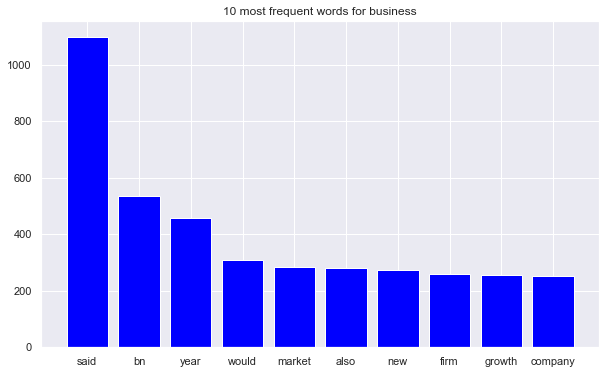

In [22]:
most_frequent_words('business')

**10 most frequent words for politics category**

said : 1445

would : 712

labour : 494

government : 464

election : 424

blair : 395

party : 376

people : 372

also : 308

minister : 286



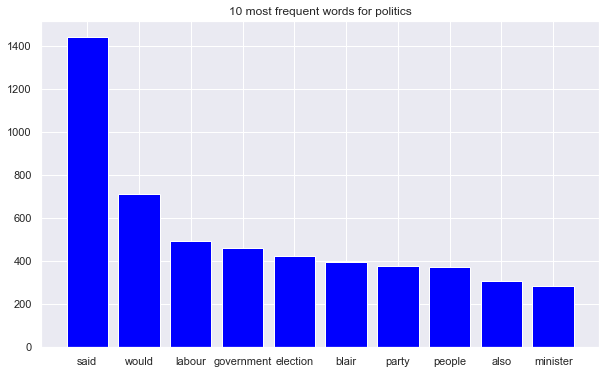

In [23]:
most_frequent_words('politics')

**10 most frequent words for sport category**

said : 636

game : 356

first : 350

year : 331

england : 329

time : 296

win : 295

two : 290

world : 269

back : 263



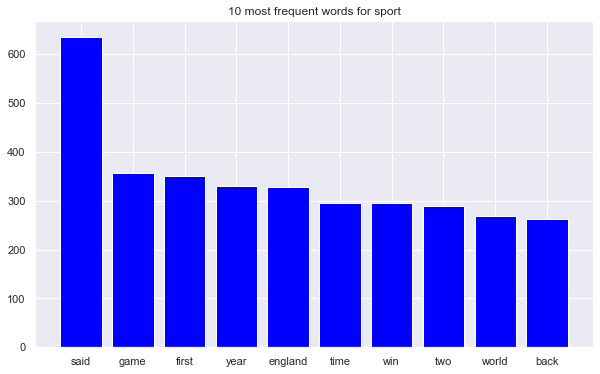

In [24]:
most_frequent_words('sport')

**10 most frequent words for tech category**

said : 1064

people : 647

one : 355

new : 349

also : 348

mobile : 343

would : 322

could : 308

technology : 303

users : 268



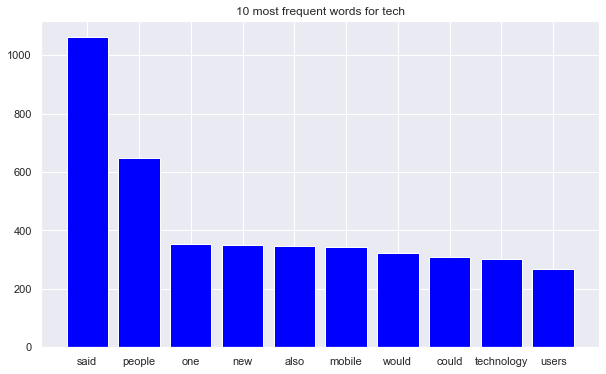

In [25]:
most_frequent_words('tech')

**10 most frequent words for entertainment category**

said : 594

film : 583

best : 430

year : 315

also : 277

one : 265

music : 255

new : 234

show : 222

first : 188



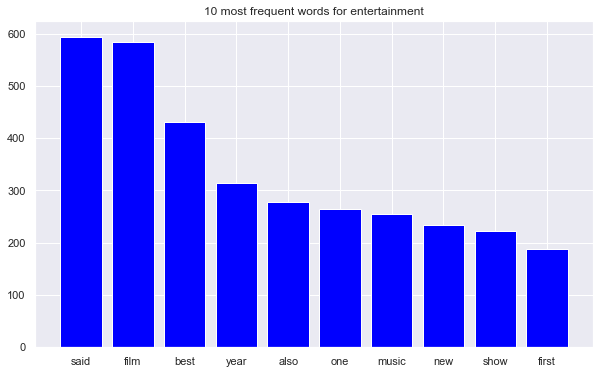

In [26]:
most_frequent_words('entertainment')

**Transforming words into feature vector:The bag-of-words model, which allows us to represent text as numerical features.**
1. Create a vocabulary of unique tokens such as words from the entire set of documents.
2. Construct a vector from each document that contains the counts of how often each word occurs in the particular document.


**A method to downweight the frequently occuring words in the feature vectors called term frequency-inverse document frequency (tf-idf). The tf-idf can be defined as the product of the term frequency and the inverse document frequency:** *tf-idf(t,d)=tf(t,d)xidf(t,d).*
<br>
**Here *tf(t,d)* is the term frequency and idf(t,d) is the inverse document frequency which is computed as follows:** *idf(t,d) = log((n)/(1+df(t,d)) where df(t,d) is the number of documents that contains the term and n is the total number of documents.*
<br>
**Please note that sklearn has all the libraries such as CountVectorizer or TfidfVectorizer that do all the works for us, you can take a look at the sklearn library for more info**

In [27]:
tfidf_vectorizer = TfidfVectorizer(lowercase = False, tokenizer = tokenizer, stop_words = 'english')
train_tfidf = tfidf_vectorizer.fit_transform(train_df['Text'])
test_tfidf = tfidf_vectorizer.transform(test_df['Text'])
train_tfidf

<1490x23113 sparse matrix of type '<class 'numpy.float64'>'
	with 203870 stored elements in Compressed Sparse Row format>

In [28]:
test_tfidf

<735x23113 sparse matrix of type '<class 'numpy.float64'>'
	with 89876 stored elements in Compressed Sparse Row format>

**After implementing TfidfVectorizer to convert text column into vector. I will save the data as X for all text vector array, and y as prediction array**

In [29]:
X = train_tfidf
X

<1490x23113 sparse matrix of type '<class 'numpy.float64'>'
	with 203870 stored elements in Compressed Sparse Row format>

In [30]:
y= train_df['Category']
y

0            business
1            business
2            business
3                tech
4            business
            ...      
1485    entertainment
1486    entertainment
1487         business
1488             tech
1489             tech
Name: Category, Length: 1490, dtype: object

**I want to develop a few help functions to caculate precision as well as recall, and to plot confusion matrix**

In [31]:
def calculate_precision(y_true, y_pred):
     
    return precision_score(y_true,y_pred, average = 'weighted')

def calculate_recall(y_true, y_pred):
   
    return recall_score(y_true,y_pred, average = 'weighted')

def plot_confusion_matrix(conf_matrix):    
        
    plt.figure(figsize=(8,6))
    
    sns.set(font_scale = 1.1)

    ax = sns.heatmap(conf_matrix, annot= True, fmt='d')
   
    ax.set_xlabel("Prediction", fontsize=14, labelpad=20)
    

    ax.set_ylabel("Actual", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(list(train_df['Category'].unique())); 
    ax.yaxis.set_ticklabels(list(train_df['Category'].unique()));

    ax.set_title("Confusion Matrix", fontsize=14, pad=20)
    plt.show()
    
def test_submit(y_pred):
    try:
        test_df['Category'] = y_pred
        submit_df = test_df.drop('Text', axis=1)
        submit_df.to_csv("submission.csv", index=False)
        print('File saved to submission.csv')
    except:
          print("Error trying to create submission.csv")

### Unsupervised Learning Using NMF


**I will use non-negative factorization method to transform X, and use the transformed matrix to classify the news into appropriate category**

In [32]:
class NMFClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=5, random_state=None, init = None, solver='cd',beta_loss = 'frobenius'):
        self.n_components = n_components
        self.random_state = random_state
        self.init = init
        self.solver = solver
        self.beta_loss = beta_loss
        self.nmf = None
        self.best_permutation = None
        self.best_accuracy = 0.0
        self.X_nmf = None
        self.y_nmf = None
    def fit(self, X, y):
        self.nmf = NMF(n_components=self.n_components, init=self.init, solver=self.solver,
                       random_state=self.random_state, beta_loss=self.beta_loss)
        
        self.X_nmf = self.nmf.fit_transform(X,y) 
        self.y_nmf = y
              
        return self
    
    def predict(self, X):
        X_nmf = self.X_nmf
        y_true = self.y_nmf
        y_pred = np.argmax(X_nmf, axis=1)
        labels = np.array(np.unique(y_true))
              
        for perm in permutations(labels):
            y_permuted = np.array([perm[label] for label in y_pred])
            accuracy = accuracy_score(y_true, y_permuted)
            if accuracy > self.best_accuracy:
                self.best_accuracy = accuracy
                self.best_permutation = perm
        y_pred = np.array([self.best_permutation[label] for label in y_pred])
        return y_pred
                

In [33]:
accuracy_score_list = []
precision_score_list = []
recall_score_list = []


# Fit and transform non-negative-matrix factorization
n_components = 5
nmf = NMFClassifier(n_components=n_components, random_state=0)


# Encode the labels
labelEncoder = preprocessing.LabelEncoder()
y = pd.DataFrame()
y = labelEncoder.fit_transform(train_df['Category'])
label_mapping = dict(zip(range(len(labelEncoder.classes_)), labelEncoder.classes_))

# Print the mapping
for encoded_label, original_label in label_mapping.items():
    print(f"Encoded Label {encoded_label} corresponds to Original Label: {original_label}")

# Perform label permutation and evaluate accuracy
nmf = nmf.fit(X,y)
y_pred = nmf.predict(X)

best_accuracy = nmf.best_accuracy
best_permutation = nmf.best_permutation
precision = calculate_precision(y,y_pred)
recall = calculate_recall(y,y_pred)

accuracy_score_list.append(best_accuracy)
precision_score_list.append(precision)
recall_score_list.append(recall)

# Print the RMSE, Best Accuracy, Train Accuracy Score and the corresponding permutation
print("RMSE:", np.sqrt(((y-y_pred)**2).mean()))
print("Best Accuracy:", best_accuracy)
print("Best Permutation:", best_permutation)
print("Train Accuracy Score: ",accuracy_score(y,y_pred))
print("Train Precision Score: ",precision)
print("Train Recall Score: ",recall)



Encoded Label 0 corresponds to Original Label: business
Encoded Label 1 corresponds to Original Label: entertainment
Encoded Label 2 corresponds to Original Label: politics
Encoded Label 3 corresponds to Original Label: sport
Encoded Label 4 corresponds to Original Label: tech
RMSE: 0.7322851976779642
Best Accuracy: 0.9241610738255034
Best Permutation: (3, 2, 4, 1, 0)
Train Accuracy Score:  0.9241610738255034
Train Precision Score:  0.9290603041781647
Train Recall Score:  0.9241610738255034


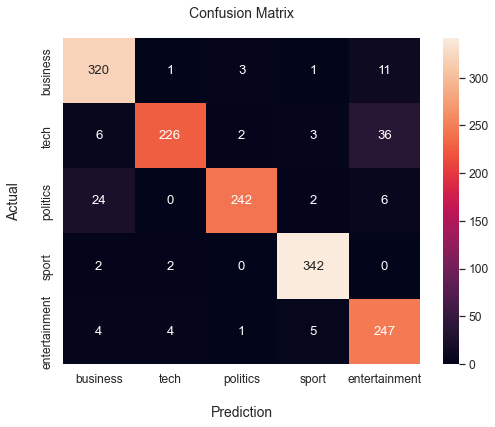

In [34]:
conf_matrix = confusion_matrix(y,y_pred)
plot_confusion_matrix(conf_matrix)

#### Hyperparameters Tuning for Unsupervised Learning

In [35]:
# Create the NMF classifier
nmf_classifier = NMFClassifier(n_components=5, random_state=0)
# Create the parameter grid
param_grid = {
    'init': ['nndsvd', 'nndsvda', 'nndsvdar'],
    'solver': ['cd', 'mu'],
    'beta_loss': ['frobenius', 'kullback-leibler', 'itakura-saito']
}
grid = GridSearchCV(nmf_classifier, param_grid, cv=5)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    # Fit the GridSearchCV object to the data
    grid.fit(X,y)

    # Get the best score and best parameters
    best_params = grid.best_params_
    print("Best Parameters:", best_params)

Best Parameters: {'beta_loss': 'frobenius', 'init': 'nndsvd', 'solver': 'cd'}


In [36]:
model = grid.best_estimator_
y_pred = model.predict(X) 
best_accuracy = model.best_accuracy
best_permutation = model.best_permutation
precision = calculate_precision(y,y_pred)
recall = calculate_recall(y,y_pred)


# Print the RMSE, Best Accuracy, Train Accuracy Score and the corresponding permutation
print("RMSE:", np.sqrt(((y-y_pred)**2).mean()))
print("Best Accuracy:", best_accuracy)
print("Best Permutation:", best_permutation)
print("Train Accuracy Score: ",accuracy_score(y,y_pred))
print("Train Precision Score: ",precision)
print("Train Recall Score: ",recall)

RMSE: 0.7322851976779642
Best Accuracy: 0.9241610738255034
Best Permutation: (3, 2, 4, 1, 0)
Train Accuracy Score:  0.9241610738255034
Train Precision Score:  0.9290603041781647
Train Recall Score:  0.9241610738255034


It just happened that I have the best parameters set already

#### Ensemble Unsupervised Learning with a Supervised Learning

In [37]:
X_nmf = model.X_nmf
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_nmf, y)
Pipeline(steps=[('standardscaler', StandardScaler()),('svc', SVC(gamma='auto'))])
y_pred = clf.predict(X_nmf)
acc_score = clf.score(X_nmf,y)
precision = calculate_precision(y,y_pred)
recall = calculate_recall(y,y_pred)

accuracy_score_list.append(acc_score)
precision_score_list.append(precision)
recall_score_list.append(recall)

print("RMSE:", np.sqrt(((y-y_pred)**2).mean()))
print("Train Precision Score: ", precision)
print("Train Recall Score: ", recall)
print("Train Accuracy Score:", acc_score)


RMSE: 0.5550258473937658
Train Precision Score:  0.9564678298649162
Train Recall Score:  0.9563758389261745
Train Accuracy Score: 0.9563758389261745


**I can see much improvement on precision, recall as well as accuracy after esnembling my unsupervised model with Support Vector Machine. The RMSE is lower than before ensembling which indicates a better model.**

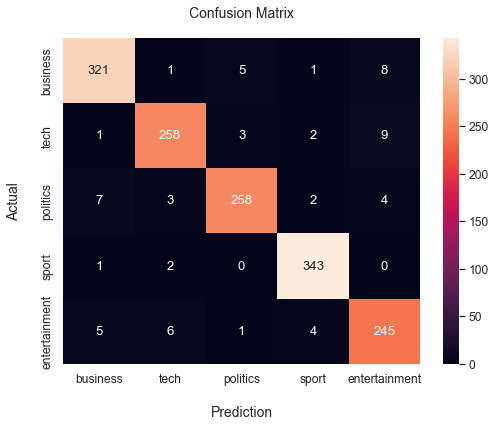

In [38]:
conf_matrix = confusion_matrix(y,y_pred)
plot_confusion_matrix(conf_matrix)

### Supervised Learning Using Logistic Regression

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.5, random_state =42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(745, 23113)
(745, 23113)
(745,)
(745,)


In [40]:
LogReg = LogisticRegression(solver='liblinear').fit(X_train,y_train)
y_pred = LogReg.predict(X_test) 
acc_score = LogReg.score(X_test,y_test)
precision = calculate_precision(y_test,y_pred)
recall = calculate_recall(y_test,y_pred)

print("RMSE:", np.sqrt(((y_test-y_pred)**2).mean()))
print("Test Precision Score: ", precision)
print("Test Recall Score: ", recall)
print("Test Accuracy Score:", acc_score)


RMSE: 0.39629153393148814
Test Precision Score:  0.9668746468033347
Test Recall Score:  0.9664429530201343
Test Accuracy Score: 0.9664429530201343


**The RMSE for Logistic Regression is lower than ensembled unsupervised learning's which indicates a better model. The precision, recall and accuracy scores are higher than ensembled unsupervised learning's.**

#### K-fold cross validation for logistic regression with 10-fold

In [41]:
model = LogisticRegression(solver ='liblinear',max_iter=1000)

y_pred = cross_val_predict(model,X_test,y_test, cv=10)

acc_score = cross_val_score(model,X_test,y_test, cv= 10)
precision = calculate_precision(y_test,y_pred)
recall = calculate_recall(y_test,y_pred)
print("Precision Score for 10-fold: ",precision)
print("Recall Score for 10-fold: ", recall)
print("Accuracy Score for 10-fold:", np.mean(acc_score))

Precision Score for 10-fold:  0.9594133316348257
Recall Score for 10-fold:  0.9583892617449664
Accuracy Score for 10-fold: 0.9583423423423424


*It does not seem like our logistic model suffers from overfitting. Let's apply GridSearchCV to find the best parameters for logistic regression.*

In [42]:
c_range = [1.0,10.0,100.0]
penalty = ['l1','l2']
parameters = {'C':c_range, 'penalty':penalty}
model = LogisticRegression(solver='liblinear', max_iter=1000)
grid = GridSearchCV(model,parameters, cv=10).fit(X_train,y_train)
print('Best Accuracy:', grid.best_score_)
print('Best Parameters:',grid.best_params_)

Best Accuracy: 0.9625405405405406
Best Parameters: {'C': 100.0, 'penalty': 'l2'}


In [43]:
model = grid.best_estimator_
y_pred = model.predict(X_test) 

acc_score = model.score(X_test,y_test)

precision = calculate_precision(y_test,y_pred)
recall = calculate_recall(y_test,y_pred)

accuracy_score_list.append(acc_score)
precision_score_list.append(precision)
recall_score_list.append(recall)

print("RMSE:", np.sqrt(((y_test-y_pred)**2).mean()))
print("Best Test Precision Score: ",precision)
print("Best Test Recall Score: ",recall)
print("Best Test Accuracy Score:", acc_score)

RMSE: 0.41611820726340176
Best Test Precision Score:  0.9690439123221989
Best Test Recall Score:  0.9691275167785235
Best Test Accuracy Score: 0.9691275167785235


*We have a slightly higher RMSE for the best estimator from our original Logistic Regression. However, the accuracy, recall and precision scores are better than the oirginal Logistic Regression*

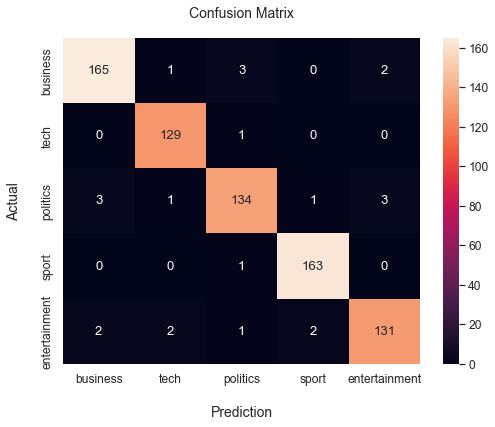

In [44]:
conf_matrix = confusion_matrix(y_test,y_pred)
conf_matrix
plot_confusion_matrix(conf_matrix)

**After finding that Logistic Regression has a better accuracy score, let's apply the Logistic Regression on the full train dataset and use that to predict the test dataset**

In [45]:
LogReg = model.fit(X,y)
y_test_pred = LogReg.predict(test_tfidf)
y_test_pred = labelEncoder.inverse_transform(y_test_pred)
test_submit(y_test_pred)
print('Submission Accuracy Score on Kaggle:', 0.98367)

File saved to submission.csv
Submission Accuracy Score on Kaggle: 0.98367


## Result, Analysis and Discussion 

In [46]:
set_type = ['Train', 'Train', 'Train 50%']
data = {'Accuracy': accuracy_score_list, 'Precision': precision_score_list, 'Recall':recall_score_list, 'Dataset': set_type}
result_df = pd.DataFrame(data)
result_df.index = ['NMF', 'NMF&SVM','Logistic Regression']
print('Model Results Comparision Table')
result_df

Model Results Comparision Table


,Accuracy,Precision,Recall,Dataset
NMF,0.924161,0.929060,0.924161,Train
NMF&SVM,0.956376,0.956468,0.956376,Train
Logistic Regression,0.969128,0.969044,0.969128,Train 50%


**The table shows that even though NMF is unsupervised learning but can predict quite well for multiclassification with accuracy about 92.4%. If we ensemble our NMF model with SVM, the accuracy improves to 95.6%. Please note that the accuracy score for unsupervised learning models achieved from the full train dataset. Meanwhile, logistic regression that was trained on 50% of train dataset, and later was used to predict the other 50% train dataset, has the best accuracy around 96.9%.** 

**Typically, NMF typically requires a sufficient amount of data to accurately capture the underlying patterns and structure. If you have a small dataset, the performance of NMF may be limited compared to supervised learning model such as Logistic Regression or SVM.  
While NMF is a powerful technique for matrix factorization, it may not be the best choice for all types of data or tasks. There could be other models or algorithms that are better suited.  
Ensembling NMF with a supervised learning model such as SVM can increase our model performance and accuracy.**

### Sources
*Transforming words into feature vectors, assessing word relevancy via term frequency-inverse document frequency - Chapter 8 of "Applying Machine Learning to Sentiment Analysis" from "Python Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2", 3rd Edition by Sebastian Raschaka & Vahid Mirjallo*